# Retrieval Augmented Generation with LangGraph

## Initial Setup

In [1]:
import os, json, re, getpass, warnings
import numpy as np
from dotenv import load_dotenv
from uuid import uuid4
from IPython.display import display, Markdown

In [2]:
warnings.filterwarnings('ignore')
load_dotenv(override=True)

True

In [3]:
#Check for Groq API Key
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("GROQ API Key: ")

## Defining Components

In [4]:
# Question
question = "What is TrueFoundry all about?"

### Chat Model

In [5]:
from langchain.chat_models import init_chat_model

model_name = "llama-3.1-8b-instant"
llm = init_chat_model(model_name, model_provider="groq") #Other Llama alternatives available are llama3-8b-8192, llama-3.3-70b-versatile

### Embedding Model

In [6]:
!ollama pull llama3.1:8b

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest 
pulling 667b0c1932bc: 100% ▕██████████████████▏ 4.9 GB                         
pulling 948af2743fc7: 100% ▕██████████████████▏ 1.5 KB                         
pulling 0ba8f0e314b4: 100% ▕██████████████████▏  12 KB                         
pulling 56bb8bd477a5: 100% ▕██████████████████▏   96 B                         
pulling 455f34728c9b: 100% ▕██████████████████▏  487 B                         
verifying sh

In [7]:
from langchain_ollama import OllamaEmbeddings

embeddings_model = OllamaEmbeddings(model="llama3.1:8b")

### Vector Store

In [23]:
#Import library
from langchain_chroma import Chroma

In [24]:
#Create a vector store
vector_store_chroma = Chroma(
    collection_name="rag_with_langgraph",
    embedding_function=embeddings_model,
    # persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

## Indexing

### Loading Documents

In [12]:
import bs4 #import Beautiful Soup
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [14]:
# Only keep the main content from the full HTML
bs4_strainer = bs4.SoupStrainer(class_=("section_gateway-banner ai", 
                                        "section_traces-features ai_gateway",
                                       "section_home-ai"))
loader = WebBaseLoader(
    web_paths=("https://www.truefoundry.com/ai-gateway", 
               "https://www.truefoundry.com"),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 2

In [15]:
# --- Post-processing to clean up excessive newlines and whitespace ---
for i, doc in enumerate(docs):
    if doc.page_content:
        # 1. Replace multiple newlines with a single newline
        cleaned_content = re.sub(r'\n\s*\n', '\n\n', doc.page_content)
        # 2. Replace multiple spaces with a single space
        cleaned_content = re.sub(r' {2,}', ' ', cleaned_content)
        # 3. Strip leading/trailing whitespace from each line
        cleaned_content = '\n'.join([line.strip() for line in cleaned_content.split('\n')])
        # 4. Remove leading/trailing whitespace from the whole string
        cleaned_content = cleaned_content.strip()
    
        docs[i].page_content = cleaned_content
# --- End of post-processing ---

### Splitting Documents

In [17]:
from langchain_experimental.text_splitter import SemanticChunker

In [18]:
#Create text splitter
text_splitter_semantic = SemanticChunker(embeddings_model)

In [19]:
len(docs[1].page_content)

647

In [20]:
#Reduce content of second doc for faster runtimes
from langchain_core.documents import Document
docs_truncated = docs.copy()
docs_truncated[1] = Document(page_content= docs[1].page_content[:5000], metadata=docs[1].metadata)

In [21]:
#Split the documents into chunks (only pick second one)
all_splits_semantic = text_splitter_semantic.split_documents(docs_truncated)
print(f"Split input into {len(all_splits_semantic)} sub-documents.")

Split input into 4 sub-documents.


In [22]:
for i in range(len(all_splits_semantic)):
    print(f"\n--- Split{i} ---\n")
    print(all_splits_semantic[i].page_content)


--- Split0 ---

Secure Deployment : VPC | On-Prem | Air-GappedAI Gateway: Fast, Scalable, Enterprise-ReadyEnterprise-Ready AI Gateway for secure, high-performance LLM access, observability, and orchestration.See detailed pricingGet Started for FreeAI Gateway: Unified LLM API AccessSimplify your GenAI stack with a single AI Gateway that integrates all major models. Connect to OpenAI, Claude, Gemini, Groq, Mistral, and 250+ LLMs through one AI Gateway API

Use the platform to support chat, completion, embedding, and reranking model types. Centralize API key management and team authentication in one place. Orchestrate multi-model workloads seamlessly through your infrastructure.Read MoreAI Gateway Observability

Monitor token usage, latency, error rates, and request volumes across your system. Store and inspect full request/response logs centrally to ensure compliance and simplify debugging. Tag traffic with metadata like user ID, team, or environment to gain granular insights. Filter lo

### Storing in Vector Store

In [25]:
#Add all chunks to vector DB
uuids = [str(uuid4()) for _ in range(len(all_splits_semantic))] #Universally unique identifier
vector_store_chroma.add_documents(documents=all_splits_semantic, ids=uuids)

['0c288e38-b127-40fc-9ed6-90681aef2964',
 '8786ce46-226e-4b4f-8f79-47a809d66d6a',
 'e51d8ce0-d060-4dca-ba4c-49debeff217d',
 'e63ba32e-98ae-44b1-a927-c0e2d56823b6']

## Retrieval and Generation with LangGraph

### Define Prompt

In [26]:
#Use Prompt Template
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


### Create Graph

In [27]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [29]:
def retrieve(state: State):
    retrieved_docs = vector_store_chroma.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [30]:
from langgraph.graph import START, StateGraph, END

graph_builder = StateGraph(State)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve","generate")
graph_builder.add_edge("generate",END)

graph = graph_builder.compile()

# # Add memory
# memory = MemorySaver()
# graph = graph_builder.compile(checkpointer=memory)

# config = {"configurable": {"thread_id": "abc123"}}

In [31]:
# from langgraph.graph import START, StateGraph

# graph_builder = StateGraph(State).add_sequence([retrieve, generate])
# graph_builder.add_edge(START, "retrieve")
# graph = graph_builder.compile()

# # # Add memory
# # memory = MemorySaver()
# # graph = graph_builder.compile(checkpointer=memory)

# # config = {"configurable": {"thread_id": "abc123"}}

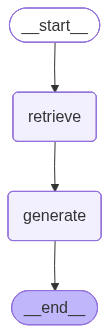

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke Graph

In [33]:
result = graph.invoke({"question": question})

## ----- To run with memory -----
# result = graph.invoke({"question": question},config)

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='e63ba32e-98ae-44b1-a927-c0e2d56823b6', metadata={'source': 'https://www.truefoundry.com'}, page_content='Orchestrate Agentic AI with AI GatewayEnable intelligent multi-step reasoning, tool usage, and memory with full control and visibility across your AI agents and workflows.AI GatewayManage agent memory, tool orchestration, and action planning through a centralized protocol that supports complex, context-aware workflows.Learn More\n\nMCP & Agents RegistryMaintain a structured, discoverable registry of tools and APIs accessible to agents, complete with schema validation and access control.Learn More\n\nPrompt Lifecycle ManagementVersion, manage, and monitor prompts to ensure high-quality, repeatable behavior across agents and use cases.Learn More'), Document(id='8786ce46-226e-4b4f-8f79-47a809d66d6a', metadata={'source': 'https://www.truefoundry.com/ai-gateway'}, page_content='Use role-based access control (RBAC) to isolate and manage usage. Govern service account